# TensorQTL Prototyping
This notebook Document a prototype workflow for using the TensorQTL in place of the APEX cis/trans to conduct analysis.

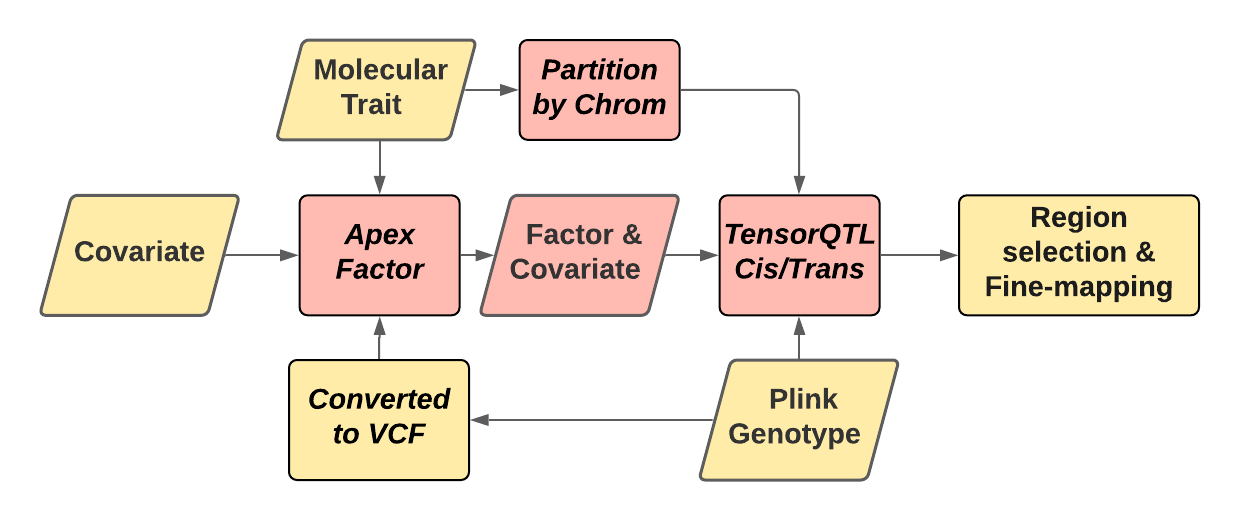

## Pre-requisites

This pipeline require the tensorQTL and R:Tidyverse. A singularity container is provided along with the mwe


# Input and Output
## Input
- `--molecular-pheno`, The text file containing the table describing the molecular phenotype. It shall have regions(genes) as rows and samples as columnes
- `--region_list` The text file with 4 columns specifying the #Chr, P0 (Start position), P1(End position) and names of regions to analyze. The name of the column is not important but the order of the columns. It is also important that the column name of the first column starts with a #. The region_list can can be generated by using another sos pipeline SOS_ROSMAP_gene_exp_processing.ipynb.


- `genotype_list` as the pipeline required whole genome vcf file for each chromosome, those vcf are converted beforehand from plink trio using the following commands:

```
for i in $(seq 1 22); do

plink --bfile /mnt/mfs/ctcn/datasets/rosmap/wgs/ampad/variants/snvCombined/plink_files/ROSMAP_chr$i \
--recode vcf-iid       --out ROSMAP_chr$i ;
bgzip ROSMAP_chr$i.vcf  ;
tabix -p vcf ROSMAP_chr$i.vcf.gz ;
tabix -H ROSMAP_chr$i.vcf.gz ;
echo $i;
done
```

- `grm_list` are a file containing list of grm matrixs that generated by the GRM module of this pipeline.



## Output





# Command interface 

In [3]:
!sos run ~/GIT/neuro-apex/apex/Apex_prototyping.ipynb -h

usage: sos run /home/hs3163/GIT/neuro-apex/apex/Apex_prototyping.ipynb
               [workflow_name | -t targets] [options] [workflow_options]
  workflow_name:        Single or combined workflows defined in this script
  targets:              One or more targets to generate
  options:              Single-hyphen sos parameters (see "sos run -h" for details)
  workflow_options:     Double-hyphen workflow-specific parameters

Workflows:
  Expression_Filtering
  apex_cis
  Factor_analysis
  LMM
  cis
  trans
  GRM

Global Workflow Options:
  --molecular-pheno-whole VAL (as path, required)
                        Path to the input molecular phenotype data.
  --ori-covariate ''
                        Covariate file, in similar format as the molecular_pheno
  --genotype-list VAL (as path, required)
                        List of Genotype file in plink trio format
  --region-list VAL (as path, required)
                        An index text file with 4 columns specifying the chr,
          

# Working example
please [download a minimal working example here](https://drive.google.com/file/d/1838xUOQuWTszQ0WJGXNiJMszY05cw3RS/view?usp=sharing), unzip the mwe file, and in the folder containing said folder run the following commands:

In [1]:
## Test pipeline with test data
## Switch back to abosolute path, otherwise there will be file not found error in step 5
nohup sos run ~/GIT/neuro-apex/apex/Apex_prototyping.ipynb apex_cis \
  --molecular_pheno_whole ./mwe/mole_pheno   \
  --wd ./ \
  --genotype_list ./mwe/mwe.genotype_list.txt \
  --region_list ./mwe/mwe_region \
  --iteration 2 \
  --container "./mwe/apex.sif" \
  --job_size 1 \
  --Prefix "MWE" \
  --grm_list "./mwe/grm/MWE.grm_list.txt" \
  -J 50 -q csg -c ~/GIT/neuro-twas/code/csg.yml &



nohup sos run ~/GIT/neuro-apex/apex/TensorQTL.ipynb tensor_cis \
  --molecular_pheno_whole ./mwe/mole_pheno   \
  --wd ./ \
  --genotype_list_tensor ./mwe/mwe.tensor_genotype \
  --region_list ./mwe/mwe_region \
  --iteration 2 \
  --container "./mwe/apex.sif" \
  --job_size 1 \
  --Prefix "MWE" \
  -J 50 -q csg -c ~/GIT/neuro-twas/code/csg.yml &


ERROR: Failed to locate twas_fusion.ipynb.sos



# Global parameter settings
The section outlined the parameters that can be set in the command interface.

In [5]:
[global]
# Path to the input molecular phenotype data.
parameter: molecular_pheno_whole = path
# Covariate file, in similar format as the molecular_pheno
parameter: ori_covariate = ""
# List of Genotype file in plink trio format
parameter: genotype_list = path("./")
# An index text file with 4 columns specifying the chr, start, end and names of regions to analyze
parameter: region_list = path
# Path to the work directory of the weight computation: output weights and cache will be saved to this directory.
parameter: wd = path('./')
# Specify the number of jobs per run.
parameter: job_size = 2
# Container option for software to run the analysis: docker or singularity
parameter: container = ''
# Prefix for the analysis output
parameter: Prefix = 'ROSMAP'
# Path to the vcf file that act as a place holder
parameter: place_holder_vcf = path("/mnt/mfs/statgen/neuro-apex/mwe/data/ROSMAP_chr2.vcf.gz")
# GRM: a prefix for the folder and prefix for the GRM of each chromosome
parameter: grm_list = path('./')

# Covariate
parameter: factor_covariate = f'{wd:a}/cache/{Prefix}.cov.gz'


## Parameter to be used (TB
# Number of latent common factors
parameter: n_of_factor = 5
# Number of factor analysis iterations (0 for PCA).                                         
parameter: iteration = 0
# Factor analysis prior
parameter: p = 0.05
parameter: tau = 0.05

# Parameter for tensor
parameter: genotype_list_tensor = path("./")



# Specify the scanning window for the up and downstream radius to analyze around the region of interest, in units of Kb
parameter: window = ['1000000']


# Get regions of interest to focus on.
regions = [x.strip().split() for x in open(region_list).readlines() if x.strip() and not x.strip().startswith('#')]


# Get the unique chormosome that have regions to be analyzed.
def extract(lst):
    return [item[0] for item in lst]
chrom = list(set(extract(regions)))




geno_inventory = dict([x.strip().split() for x in open(genotype_list).readlines() if x.strip() and not x.strip().startswith('#')])
geno_inventory_tensor = dict([x.strip().split() for x in open(genotype_list_tensor).readlines() if x.strip() and not x.strip().startswith('#')])


import os
def get_genotype_file(chrom, genotype_list, geno_inventory):
    chrom = f'{chrom}'
    if chrom.startswith('chr'):
        chrom = chrom[3:]
    if chrom not in geno_inventory:
        geno_file = f'{chrom}'
    else:
        geno_file = geno_inventory[chrom]
    if not os.path.isfile(geno_file):
        # relative path
        if not os.path.isfile(f'{genotype_list:ad}/' + geno_file):
            raise ValueError(f"Cannot find genotype file {geno_file}")
        else:
            geno_file = f'{genotype_list:ad}/' + geno_file
    return path(geno_file)



geno_inventory = dict([x.strip().split() for x in open(genotype_list).readlines() if x.strip() and not x.strip().startswith('#')])

def get_genotype_file(chrom, genotype_list, geno_inventory):
    chrom = f'{chrom}'
    if chrom.startswith('chr'):
        chrom = chrom[3:]
    if chrom not in geno_inventory:
        geno_file = f'{chrom}'
    else:
        geno_file = geno_inventory[chrom]
    if not os.path.isfile(geno_file):
        # relative path
        if not os.path.isfile(f'{genotype_list:ad}/' + geno_file):
            raise ValueError(f"Cannot find genotype file {geno_file}")
        else:
            geno_file = f'{genotype_list:ad}/' + geno_file
    return path(geno_file)

grm_inventory = dict([x.strip().split() for x in open(grm_list).readlines() if x.strip() and not x.strip().startswith('#')])

def get_grm_file(chrom, grm_list, grm_inventory):
    chrom = f'{chrom}'
    if chrom.startswith('chr'):
        chrom = chrom[3:]
    if chrom not in grm_inventory:
        grm_file = f'{chrom}'
    else:
        grm_file = grm_inventory[chrom]
    if not os.path.isfile(grm_file):
        # relative path
        if not os.path.isfile(f'{grm_list:ad}/' + grm_file):
            raise ValueError(f"Cannot find grm file {grm_file}")
        else:
            grm_file = f'{grm_list:ad}/' + grm_file
    return path(grm_file)






## Filter of the phenotype according to the regions data

In [ ]:
[Expression_Filtering_1,apex_cis_1]
input: molecular_pheno_whole,region_list
output: f'{wd}/data/{Prefix}.mol_phe.tmp.bed.gz',
        molecular_pheno = f'{wd}/data/{Prefix}.mol_phe.bed'
task: trunk_workers = 1, trunk_size = 1, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    pheno = read_delim("$[_input[0]]",delim = "\t")
    region = read_delim("$[_input[1]]",delim = "\t")
    output = inner_join(region, pheno , by = "gene_ID")%>%arrange(`#chr`,start_position)
    output%>%write_delim("$[_output[0]:n]",delim = "\t")
    output%>%write_delim("$[_output[1]]",delim = "\t")
  
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    if test -f "$[_output[0]]"; then
    echo "$[_output[0]] exists."
    else
    bgzip $[_output[0]:n]
    fi
    tabix -p bed $[_output[0]] -f

## Partition of the molecular phenotype for each chromosome
This step extracts the molecular phenotype for each gene, the end position of the gene will be recoded as the TSS to be complied with the requirement of both APEX and TensorQTL

In [ ]:
[Expression_Filtering_2,apex_cis_2]
input: output_from('apex_cis_1'),for_each = "chrom"
output: f'{wd}/cache/{Prefix}.chr{_chrom}.mol_phe.bed.gz'
task: trunk_workers = 1, trunk_size = 1, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
R: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    library("dplyr")
    library("tibble")
    library("readr")
    library("modelr")
    library("purrr")
    pheno = read_delim("$[_input[1]]",delim = "\t")
    colnames(pheno)[2:3] = c("start","end")
    pheno = pheno%>%mutate(end = start +1)
    pheno%>%write_delim("$[_output[0]:n]",delim = "\t")
  
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    if test -f "$[_output[0]]"; then
    echo "$[_output[0]] exists."
    else
    bgzip $[_output[0]:n]
    fi
    tabix -p bed $[_output[0]] -f

## Apex Factor analysis

In [ ]:
[Factor_analysis,apex_cis_3]
input:  output_from('apex_cis_1')
output: f'{wd:a}/cache/{Prefix}.cov.gz',
        f'{wd:a}/cache/{Prefix}.cov'
geno_file = get_genotype_file(chrom[0], genotype_list, geno_inventory)
task: trunk_workers = 1, trunk_size = 1, walltime = '4h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand = "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout',container = container,volumes = [f'{wd:ad}:{genotype_list:ad}']
    apex factor --vcf $[geno_file:a] \
    --out $[_output:nn] \
    --iter $[iteration] \
    --cov "$[ori_covariate]" \
    --factors $[n_of_factor] \
    --bed $[_input[0]]
    gunzip -f -k $[_output[0]]

## LMM Regression  
This step are done to precompute and store a) LMM null models and trait residuals and b) spline terms for LMM genotypic variances to speed up downstream analysis

In [ ]:
[LMM,apex_cis_4]
input: output_from('apex_cis_2',group_with = "chrom"),output_from('apex_cis_3')
parameter: window = 100000
geno_file = get_genotype_file(_chrom, genotype_list, geno_inventory)
GRM = get_grm_file(_chrom, grm_list, grm_inventory)
output: f'{_input[0]:nn}.theta.gz'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '20G', tags = f'{step_name}_{_output[0]:bn}'
bash: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout', container = container, volumes = [f'{genotype_list:ad}:{genotype_list:ad}']
    apex lmm --vcf $[geno_file] \
    --bed $[_input[0]] \
    --cov $[factor_covariate] \
    --out $[_input[0]:nn] \
    --grm $[GRM] \
    --fit-null \
    --save-resid \
    --write-gvar
    

## QTL Sumstat generation  
This step generate the cis-QTL summary statistics and vcov (covariate-adjusted LD) files for downstream analysis from summary statistics. The analysis is done per chromosome to reduce running time.

## QTL Sumstat generation via tensorQTL



In [ ]:
[tensor_cis]
input: output_from('apex_cis_2',group_with = "chrom"),output_from('apex_cis_3')
geno_file = get_genotype_file(_chrom, genotype_list_tensor, geno_inventory_tensor)
output: f'{wd:a}/tensorQTL/{Prefix}.cis_qtl_pairs.{_chrom}.parquet',
        f'{wd:a}/tensorQTL/{Prefix}.cis_qtl_pairs.{_chrom}.norminal.cis_long_table.txt',
        f'{wd:a}/tensorQTL/{Prefix}.cis_qtl_pairs.{_chrom}.emprical.cis_sumstats.txt'
task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'
python: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout'
    import pandas as pd
    import numpy as np
    import tensorqtl
    from tensorqtl import genotypeio, cis, trans
    ## Defineing parameter
    plink_prefix_path = $[geno_file:r]
    expression_bed = $[_input[0]:r]
    covariates_file = "$[_input[1]]"
    Prefix = "$[_output[0]:nnn]"
    ## Loading Data
    phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
    covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
    pr = genotypeio.PlinkReader(plink_prefix_path)
    genotype_df = pr.load_genotypes()
    variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]
    ## Retaining only common samples
    phenotype_df = phenotype_df[np.intersect1d(phenotype_df.columns, covariates_df.index)]
    ## cis-QTL mapping: nominal associations for all variant-phenotype pairs
    cis.map_nominal(genotype_df, variant_df,
                phenotype_df.loc[phenotype_pos_df['chr']=='$[_chrom]'],
                phenotype_pos_df.loc[phenotype_pos_df['chr']=='$[_chrom]'],
                Prefix, covariates_df=covariates_df)
    ## Load the parquet and save it as txt
    pairs_df = pd.read_parquet("$[_output[0]]")
    pairs_df.columns.values[0]  = "gene_ID"
    pairs_df.to_csv("$[_output[1]]", sep='\t',index = None)
    
    ## cis-QTL mapping: empirical p-values for phenotypes
    cis_df = cis.map_cis(genotype_df, variant_df, 
                     phenotype_df.loc[phenotype_pos_df['chr']=='$[_chrom]'],
                     phenotype_pos_df.loc[phenotype_pos_df['chr']=='$[_chrom]'],
                     covariates_df=covariates_df, seed=999)
    cis_df.index.name = "gene_ID"
    cis_df.to_csv("$[_output[2]]", sep='\t')

In [ ]:
[tensor_trans]
input: output_from('apex_cis_2',group_with = "chrom"),output_from('apex_cis_3')
geno_file = get_genotype_file(_chrom, genotype_list_tensor, geno_inventory_tensor)
output: f'{wd:a}/tensorQTL/{Prefix}.cis_qtl_pairs.{_chrom}.trans_sumstats.txt'

parameter: batch_size = 10000
parameter: pval_threshold = 1e-5
parameter: maf_threshold = 0.05


task: trunk_workers = 1, trunk_size = 1, walltime = '12h',  mem = '40G', tags = f'{step_name}_{_output[0]:bn}'

python: expand= "$[ ]", stderr = f'{_output[0]}.stderr', stdout = f'{_output[0]}.stdout'
    import pandas as pd
    import numpy as np
    import tensorqtl
    from tensorqtl import genotypeio, cis, trans
    ## Defineing parameter
    plink_prefix_path = $[geno_file:r]
    expression_bed = $[_input[0]:r]
    covariates_file = "$[_input[1]]"
    Prefix = "$[_output[0]:nnn]"
    ## Loading Data
    phenotype_df, phenotype_pos_df = tensorqtl.read_phenotype_bed(expression_bed)
    covariates_df = pd.read_csv(covariates_file, sep='\t', index_col=0).T
    pr = genotypeio.PlinkReader(plink_prefix_path)
    genotype_df = pr.load_genotypes()
    variant_df = pr.bim.set_index('snp')[['chrom', 'pos']]
    ## Retaining only common samples
    phenotype_df = phenotype_df[np.intersect1d(phenotype_df.columns, covariates_df.index)]
    ## Trans analysis
    trans_df = trans.map_trans(genotype_df, phenotype_df, covariates_df, batch_size=$[batch_size],
                           return_sparse=True, pval_threshold=$[pval_threshold], maf_threshold=$[maf_threshold])

    ## Filter out cis signal
    trans_df = trans.filter_cis(trans_df, phenotype_pos_df.T.to_dict(), variant_df, window=$[window])
    ## Output
    trans_df.columns.values[1]  = "gene_ID"
    trans_df.to_csv("$[_output[0]]", sep='\t')